In [22]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt    
from math import pi
import scipy.stats
from datetime import datetime

df_1 = pd.read_csv("./Escenario/resultados_esc3.jtl")


In [23]:
def getElapsedData(df, label):

    print('Start time at: ', startTime);
    print('End time at: ', endTime);

    if (label != False):
        df_new = df[df['label'] == label]
        df_new = df_new[(df_new['timeStamp']) > startTime]
    else:
        df_new = df[(df['timeStamp']) > startTime]
    df_new = df_new[(df_new['timeStamp'] + df_new['elapsed'] < endTime)]
    df_new_timestamp = df_new[df_new['responseCode'] == 200]['timeStamp']
    df_new_elapsed = df_new[df_new['responseCode'] == 200]['elapsed']
    df_new_error = df_new[df_new['responseCode'] != 200]
    return [df_new_elapsed, df_new_timestamp, df_new_error]

In [74]:
firstTimestamp = df_1.iloc[0]['timeStamp']

intervalDuration = (5 * 60 * 1000)
startupTime = (10*1000)

startTime = firstTimestamp + startupTime
endTime = startTime + intervalDuration

[df_1_elapsed, df_1_timestamp, df_1_error] = getElapsedData(df_1, False)
print(df_1_elapsed.median())



Start time at:  1621601796266
End time at:  1621602096266
9486.0


In [25]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

In [26]:
def getRow(data, timestamps, thinkTime, hilos):
    minResponseTime = maxResponseTime = meanResponseTime = medianResponseTime = modeResponseTime = totalTime = std = rango = iqr = numRequest = throughput = potencia = confidence_interval = 0
    if (data.count() > 0):
        minResponseTime = data.min()
        maxResponseTime = data.max()
        meanResponseTime = data.mean()
        medianResponseTime = data.median()
        modeResponseTime = data.mode()
        totalTime = data.sum()

        std = data.std(ddof=0)
        cov = std/meanResponseTime


        iqr = data.quantile(0.75) - data.quantile(0.25)

        numRequest = data.size
        arrivalsRate = numRequest/(intervalDuration/1000)
        throughput = (numRequest/240)
        confidence_interval = mean_confidence_interval(data)

        timestamps_diff = np.absolute(np.diff(np.sort(timestamps)))
        interArrivalsRateMean = timestamps_diff.mean()
        interArrivalsRateStd = timestamps_diff.std(ddof=0)
        interArrivalsRateCoV = interArrivalsRateStd/interArrivalsRateMean
    
    return [hilos, thinkTime, meanResponseTime, std, numRequest, arrivalsRate, interArrivalsRateMean, interArrivalsRateStd, interArrivalsRateCoV, throughput, confidence_interval];


In [27]:
data = [getRow(df_1_elapsed, df_1_timestamp, 42000, 300)];

columns = ['N', 'Z', 'Media (ms)', 'Desv. std (ms)', 'N. Peticiones', 'λ (ojb/s)', 'T. entre llegadas medio (ms)', 'T. entre llegadas StdDev (ms)', 'T. entre llegadas CoV', 'Throughput (ojb/s)', 'Mean Confidence Interval (ms, ms)']
  

df = pd.DataFrame(data, columns = columns) 
  
df 

N      Z    Media (ms)  Desv. std (ms)  N. Peticiones  λ (ojb/s)  \
0  300  42000  19426.552769    18578.766892           2113   7.043333   

   T. entre llegadas medio (ms)  T. entre llegadas StdDev (ms)  \
0                    135.442235                     141.407222   

   T. entre llegadas CoV  Throughput (ojb/s)  \
0               1.044041            8.804167   

         Mean Confidence Interval (ms, ms)  
0  (18633.74667741478, 20219.358859736192)

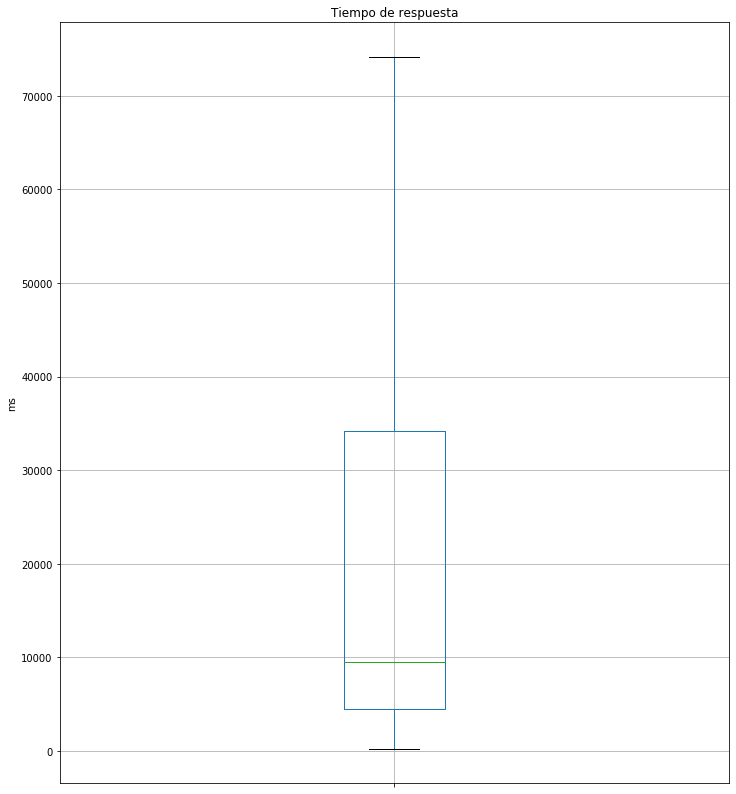

In [75]:
allDf = pd.concat(
    [df_1_elapsed], axis = 1, keys=[''])
bplot = allDf.boxplot( figsize=(12,14))
bplot.set_ylabel('ms')
bplot.set_title('Tiempo de respuesta')
plt.show()


Text(0, 0.5, '%')

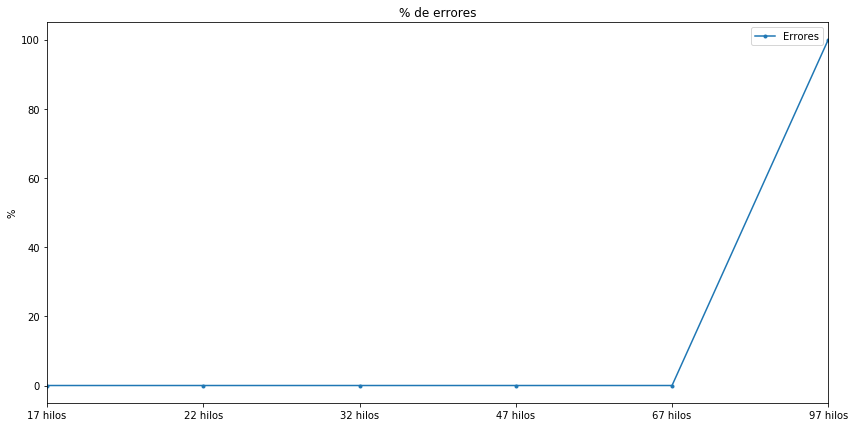

In [26]:
df_errors = {
    'Errores': [
        (df_1_error['elapsed'].count()/df_1['elapsed'].count())*100,
        (df_2_error['elapsed'].count()/df_2['elapsed'].count())*100,
        (df_3_error['elapsed'].count()/df_3['elapsed'].count())*100,
        (df_4_error['elapsed'].count()/df_4['elapsed'].count())*100,
        (df_5_error['elapsed'].count()/df_5['elapsed'].count())*100,
        (df_6_error['elapsed'].count()/df_6['elapsed'].count())*100
    ]
}
df_errors = pd.DataFrame(data=df_errors, index=keys)
ax = df_errors.plot(title = '% de errores', style = '.-', figsize=(14, 7))
ax.set_ylabel("%")



In [88]:
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



In [89]:
df_perf = pd.read_csv("./Escenario/log_perfmon.csv")

firstTimestamp = df_perf.iloc[0]['timeStamp']
startupTime = (10*1000)
holdLoadTime = (120*1000)

startTime_1 = firstTimestamp + startupTime
endTime_1 = startTime_1 + holdLoadTime

df_disk_1 = df_perf[df_perf['label'] == 'virtual.lab.inf.uva.es Disks I/O queue']['elapsed']
df_tcp_1 = df_perf[df_perf['label'] == 'virtual.lab.inf.uva.es TCP estab']['elapsed']
df_mem_1 = df_perf[df_perf['label'] == 'virtual.lab.inf.uva.es Memory usedperc']['elapsed'] / 1000
df_cpu_1 = df_perf[df_perf['label'] == 'virtual.lab.inf.uva.es CPU user']['elapsed'] / 1000


In [90]:
def getPerfmonRow(data):
    disk = data[data['label'] == 'virtual.lab.inf.uva.es Disks I/O queue']['elapsed']
    tcp = data[data['label'] == 'virtual.lab.inf.uva.es TCP estab']['elapsed']
    memory = data[data['label'] == 'virtual.lab.inf.uva.es Memory usedperc']['elapsed']
    cpu = data[data['label'] == 'virtual.lab.inf.uva.es CPU user']['elapsed']
    
    meanDisk = meanTcp = meanMemory = meanCpu = 0
    if (disk.count() > 0):
        meanDisk = disk.mean()
    if (tcp.count() > 0):
        meanTcp = tcp.mean() / 100
    if (memory.count() > 0):
        meanMemory = memory.mean() / 1000
    if (cpu.count() > 0):
        meanCpu = cpu.mean() / 1000
    
    return [meanCpu, meanMemory, meanTcp, meanDisk];

In [91]:
data = [
    getPerfmonRow(df_perf)
];

columns = ['CPU', 'Memory', 'Tcp', 'Disk']
  
df = pd.DataFrame(data, columns = columns) 
  
df

CPU     Memory          Tcp     Disk
0  77.335577  27.574117  2716.380368  0.09816

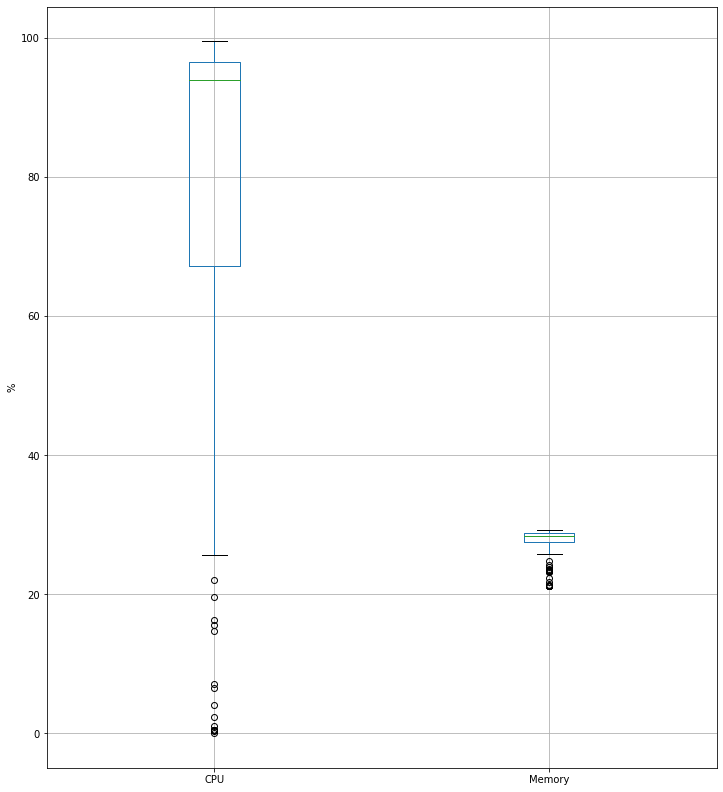

In [97]:
keys = ['CPU', 'Memory']
allDf = pd.concat([df_cpu_1, df_mem_1], axis=1, keys=keys)
bplot = allDf.boxplot(
    column=keys,
    labels=keys,
    vert=True,
    figsize=(12,14)
)
bplot.set_ylabel("%")

plt.show()